# Load global images

In [19]:
import sys
sys.path.append('../../elpv-dataset/utils')
from elpv_reader import load_dataset


import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os
from tqdm import tqdm # for loading progress
root = ""
images, probas, types = load_dataset()

### Preprocess Images

In [ ]:
import os
import cv2

# using images from dataset

# Create a folder to save the processed images
output_folder = "../elpv-dataset/images"
os.makedirs(output_folder, exist_ok=True)

# Apply histogram equalization to each image and save it to the folder
for i, image in enumerate(images):
    # Convert to uint8 (assuming your image has values in the range [0, 255])
    image_uint8 = cv2.convertScaleAbs(image)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(image_uint8)

    # Save the processed image to the output folder
    output_path = os.path.join(output_folder, f"cell{i+1:04d}.png")
    cv2.imwrite(output_path, equalized_image)

print("Histogram equalization and saving complete.")

# Feature Descriptors

In [20]:

# Vlad with power norm, l2 norm, PCA whitening
from typing import *
from dataclasses import dataclass, field
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.decomposition import PCA
import numpy as np
import os
import pickle as pkl

from sklearn.model_selection import train_test_split

class KeypointDetector:
    keypoint_instance: Any
    name: str
    kwargs: Dict[str, Any]
    def compute(self, images):
        """
            Returns:
                all descriptors for each image    
        """
        self.num_descriptors = 0
        descriptors_list = [self._compute(img) for img in tqdm(images, total=len(images), desc='Extracting Key Points')]
        return descriptors_list

    def filename(self):
        name = f'{self.name}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.kwargs.items())
        name += ')'
        return name

    def _compute(self, image):
        return self.keypoint_instance.detect(image)


class FeatureDescriptor:
    descriptor_instance: Any
    name: str
    kwargs: Dict[str, Any]


    def compute(self, images, keypoints):
        """
            Returns:
                all descriptors for each image    
        """
        assert(len(images) == len(keypoints))
        self.num_descriptors = 0
        descriptors_list = [self._compute(img, kp) for img, kp in zip(tqdm(images, total=len(images), desc='Extracting Features'), keypoints)]
        return descriptors_list
    
    def filename(self):
        name = f'{self.name}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.kwargs.items())
        name += ')'
        return name
    
    def _compute(self, image, keypoints):
        return self.descriptor_instance.compute(image, keypoints)[1]
    
class SiftKP(KeypointDetector):
    def __init__(self, **kwargs):
        self.name = 'siftkp'
        self.keypoint_instance = cv.SIFT_create(**kwargs) 
        self.kwargs = kwargs # important for logging params 

class KazeKP(KeypointDetector):
    # thresh = 0.0001 good
    def __init__(self, **kwargs):
        self.name = 'kaze'
        self.keypoint_instance = cv.KAZE_create(**kwargs) 
        self.kwargs = kwargs

class AgastKP(KeypointDetector):
    # thresh=3 good
    def __init__(self, **kwargs):
        self.name = 'agast'
        self.keypoint_instance = cv.AgastFeatureDetector_create(**kwargs) 
        self.kwargs = kwargs  

###

class SiftFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'siftfd'
        self.descriptor_instance = cv.SIFT_create(**kwargs)
        self.kwargs = kwargs

class SurfFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'kaze'
        self.descriptor_instance = cv.KAZE_create(**kwargs) 
        self.kwargs = kwargs


class OrbFD(FeatureDescriptor):
    def __init__(self, **kwargs):
        self.name = 'orb'
        self.descriptor_instance = cv.ORB_create(**kwargs)
        self.kwargs = kwargs




def compute_or_cache_fd(kp: KeypointDetector, fd: FeatureDescriptor, random_seed: int=42, amt: int = -1):
    '''
    Caches  

    kp: keypoint detector class
    fd: feature descriptor class
    random_seed: the seed with which to split test/training data. Split is automatically done with 75% test, 25% train
    amt: How much data to compute - useful for testing purposes. If left blank, it will compute for all the data.

    The guarantee is that train + test = amt if amt is less than the total data size.

    If amt is greater than the data recieved from the cache, then we will recompute to fulfill the query.
    
    '''
    fname = f'{kp.filename()}_{fd.filename()}_{random_seed}.pkl'
    if amt <= 0:
        amt = len(images)
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            x_desc_train, x_desc_test, y_train, y_test, t_train, t_test = pkl.load(f) 
        if len(x_desc_train) + len(x_desc_test) >= amt:
            test_amt = amt//4
            train_amt = amt - test_amt
            x_desc_train, x_desc_test, y_train, y_test, t_train, t_test =  x_desc_train[:train_amt], x_desc_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
            return x_desc_train, x_desc_test, y_train, y_test, t_train, t_test
    # For whatever reason, we need to compute all the keypoints again.
    x_train, x_test, y_train, y_test, t_train, t_test = train_test_split(images, probas, types, test_size=0.25, random_state=random_seed)
    if amt < len(images):
        test_amt = amt//4
        train_amt = amt - test_amt
        x_train, x_test, y_train, y_test, t_train, t_test = x_train[:train_amt], x_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
    x_desc_train = fd.compute(x_train, kp.compute(x_train))
    x_desc_test = fd.compute(x_test, kp.compute(x_test))
    ret = (x_desc_train, x_desc_test, y_train, y_test, t_train, t_test)
    with open(fname, 'wb') as f:
        pkl.dump(ret, f)
    return ret




In [21]:

compute_or_cache_fd(AgastKP(threshold=3), SiftFD())
compute_or_cache_fd(KazeKP(threshold=0.0001), SiftFD())

([array([[  0.,   0.,   0., ...,  19., 127.,  17.],
         [  0.,   0.,   0., ...,  35., 146.,   3.],
         [  0.,   0.,   0., ...,  18., 112.,  22.],
         ...,
         [  3.,  48.,  48., ...,   0.,   0.,   0.],
         [116.,   0.,   0., ...,  11.,   0.,   0.],
         [ 16.,  52.,  47., ...,  14.,   1.,   1.]], dtype=float32),
  array([[  0.,   0.,   0., ...,  46.,  98.,  28.],
         [  0.,   0.,   0., ...,   5., 120.,  46.],
         [  0.,   0.,   0., ...,  80.,   0.,   0.],
         ...,
         [ 25.,   2.,   1., ...,   1.,  25.,  71.],
         [  9.,  34.,  34., ...,  28.,  14.,   2.],
         [  1.,   2.,  30., ...,   0.,   0.,   0.]], dtype=float32),
  array([[  0.,   0.,   0., ...,  98.,  92.,  24.],
         [  0.,   0.,   0., ...,   7.,  42., 117.],
         [  0.,   0.,   0., ...,   2.,  82., 101.],
         ...,
         [ 40.,  47.,  25., ...,   1.,  59.,  21.],
         [  0.,   0.,   0., ...,   8.,   1.,   0.],
         [  0.,   1.,  15., ...,   0.,  

In [22]:

compute_or_cache_fd(AgastKP(threshold=3), OrbFD())
compute_or_cache_fd(KazeKP(threshold=0.0001), OrbFD())

([array([[241, 162, 205, ..., 200, 210,  32],
         [241, 160, 205, ..., 200, 242,  40],
         [245,  48, 237, ..., 203, 242, 112],
         ...,
         [  3, 219,  34, ...,  14, 185, 221],
         [210,  74,  14, ...,  49,  37,  74],
         [ 58,  67,  99, ..., 158, 116, 255]], dtype=uint8),
  array([[202,   2,  28, ...,  36,  13,  67],
         [112, 120, 191, ..., 176,   6, 122],
         [237, 116, 189, ..., 241, 194, 112],
         ...,
         [ 26,  74, 106, ..., 180,  45,  93],
         [177, 237, 125, ..., 137, 198,  40],
         [ 59, 179, 195, ..., 132, 250, 221]], dtype=uint8),
  array([[241, 174, 239, ..., 200, 242,  41],
         [241, 186, 207, ..., 200, 242,  57],
         [249, 186, 239, ..., 200, 242,  57],
         ...,
         [220,  80, 188, ...,  49,   5,  98],
         [ 14,  93,  56, ...,  55,  13, 215],
         [ 11, 223,  66, ..., 206, 185, 221]], dtype=uint8),
  array([[249, 182, 237, ..., 200, 242,  57],
         [206, 124, 191, ..., 113,   7,

In [23]:

compute_or_cache_fd(SiftKP(), SiftFD())
# compute_or_cache_fd(SiftKP(), OrbFD()) # needs 78gb of memory for some reason

([array([[ 64.,   0.,   0., ...,   0.,   0.,   1.],
         [130.,  16.,   0., ...,   0.,   0.,  22.],
         [134.,   5.,   0., ...,   1.,   5.,   4.],
         ...,
         [ 12.,   0.,   0., ..., 100., 135.,   0.],
         [140.,   3.,   0., ...,   0.,   0.,   0.],
         [ 50.,   3.,   0., ...,   0.,   0.,   1.]], dtype=float32),
  array([[ 49.,   3.,   0., ...,   0.,   1.,  16.],
         [ 10.,   0.,   0., ...,   1.,  67., 130.],
         [125.,  10.,   0., ...,  22.,  33.,   5.],
         ...,
         [ 32., 141.,  18., ...,  25.,   3.,   0.],
         [  0.,   0.,   0., ...,   2.,   3.,   1.],
         [  3.,   0.,   0., ...,  30.,  70.,   1.]], dtype=float32),
  array([[89., 16.,  0., ...,  0.,  7., 79.],
         [77., 15.,  0., ...,  0., 37., 53.],
         [23.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [90.,  9.,  0., ...,  0.,  1., 49.],
         [32.,  0.,  0., ...,  0.,  0.,  0.],
         [67.,  5.,  0., ...,  0.,  1., 32.]], dtype=float32),
  array


compute_or_cache(SiftKP(threshold=3), OrbFD())
compute_or_cache(SiftKP(threshold=0.0001), OrbFD())

# Encoding

In [24]:
from dataclasses import dataclass
from sklearn.cluster import KMeans, MiniBatchKMeans


@dataclass
class CustomEncoder:
    def filename(self):
        name = f'{self.__class__.__name__.lower()}('
        name += ','.join(f'{k[:3]}={v}' for k, v in self.__dict__.items() if self.__dataclass_fields__[k].default != v)
        name += ')'
        return name
    
    def fit_transform(self, descriptors_list: List[Any]) -> Any:
        ...

    def fit(self, descriptors_list: List[Any]) -> Any:
        self.fit_transform(descriptors_list)

    def transform(self, descriptors_list: List[Any]) -> Any:
        ...

@dataclass
class Vlad(CustomEncoder):
    rho: float
    vlad_clusters: int = 6
    output_size: int = 1000
    pca_tol: float = 0.1
    
    _clust_model: Union[KMeans, MiniBatchKMeans] = field(init=False)
    _pca_model: PCA = field(init=False)
    _descriptor_size: int = field(init=False)


    def fit_transform(self, descriptors_list: List[Any]):
        all_descriptors = np.vstack([i for i in descriptors_list if i is not None]) 
        self.descriptor_size = len(all_descriptors[0])
        self._clust_model = MiniBatchKMeans(n_clusters=self.vlad_clusters, random_state=0) # centers are mu_k
        self._clust_model.fit(all_descriptors)
        self._pca_model = PCA(whiten=True, tol=0.1)
        all_vlad_vectors = []

        for descriptors in tqdm(descriptors_list, desc='Vlad.fit: Sampling all vlad_vectors'):
            all_vlad_vectors.append(self._vlad(descriptors))
        
        results = self._pca_model.fit_transform(np.array(all_vlad_vectors))
        self.output_size = min(self.output_size, self._pca_model.n_components_)
        return results[:, :self.output_size]
    
    def fit(self, images):
        self.fit_transform(images)

    def _vlad(self, descriptors):
        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image

        k = self.vlad_clusters
        vlad_vector = np.zeros((k, self.descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = self._clust_model.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            vlad_vector[cluster_idx] += (descriptors[idx] - self._clust_model.cluster_centers_[cluster_idx])

        # Power normalization
        vlad_vector = (np.sign(vlad_vector) * np.abs(vlad_vector) ** self.rho).flatten()
        
        # l2 Normalization
        return vlad_vector/np.linalg.norm(vlad_vector)  # Normalize each row independently
 
    def _pca(self, vlad_vector):
        return self._pca_model.transform(vlad_vector)[:, :self.output_size]

    def transform(self, descriptors_list):    
        vecs = np.zeros((len(descriptors_list), self.descriptor_size*self.vlad_clusters))
        for i in tqdm(range(len(descriptors_list)), desc='Vlad.transform'):
            vecs[i] = self._vlad(descriptors_list[i])
        return self._pca(vecs)
    

class Vlaad(Vlad):
    def _vlad(self, descriptors):
        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image

        k = self.vlad_clusters
        vlad_vector = np.zeros((k, self.descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = self._clust_model.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            residue = descriptors[idx] - self._clust_model.cluster_centers_[cluster_idx]
            vlad_vector[cluster_idx] += residue*np.linalg.norm(residue) 

        # Power normalization
        vlad_vector = (np.sign(vlad_vector) * np.abs(vlad_vector) ** self.rho).flatten()
        return vlad_vector/np.linalg.norm(vlad_vector)


def compute_or_cache_fv(enc: CustomEncoder, kp: KeypointDetector, fd: FeatureDescriptor, random_seed: int=42, amt: int = -1):
    '''
    Caches encoder feature vectors

    enc: Encoder class
    kp: keypoint detector class
    fd: feature descriptor class
    random_seed: the seed with which to split test/training data. Split is automatically done with 75% test, 25% train
    amt: How much data to compute - useful for testing purposes. If left blank, it will compute for all the data.

    The guarantee is that train + test = amt if amt is less than the total data size.

    If amt is greater than the data recieved from the cache, then we will recompute to fulfill the query.
    
    '''
    fname = f'{enc.filename()}_{kp.filename()}_{fd.filename()}_{random_seed}.pkl'
    if amt <= 0:
        amt = len(images)    
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            x_fv_train, x_fv_test, y_train, y_test, t_train, t_test = pkl.load(f) 
        if len(x_fv_train) + len(x_fv_test) >= amt:
            test_amt = amt//4
            train_amt = amt - test_amt
            x_fv_train, x_fv_test, y_train, y_test, t_train, t_test =  x_fv_train[:train_amt], x_fv_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
            return x_fv_train, x_fv_test, y_train, y_test, t_train, t_test
    # For whatever reason, we need to compute all the keypoints again.
    x_dec_train, x_desc_test, y_train, y_test, t_train, t_test = compute_or_cache_fd(kp, fd, random_seed, amt)
    if amt < len(images):
        test_amt = amt//4
        train_amt = amt - test_amt
        x_dec_train, x_desc_test, y_train, y_test, t_train, t_test = x_dec_train[:train_amt], x_desc_test[:test_amt], y_train[:train_amt], y_test[:test_amt], t_train[:train_amt], t_test[:test_amt] 
    x_fv_train = enc.fit_transform(x_dec_train)
    x_fv_test = enc.transform(x_desc_test)
    ret = (x_fv_train, x_fv_test, y_train, y_test, t_train, t_test)
    with open(fname, 'wb') as f:
        pkl.dump(ret, f)
    return ret


In [25]:
compute_or_cache_fv(Vlad(0.5), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlad(1), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlaad(0.5), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlaad(1), KazeKP(threshold=0.0001), SiftFD())


(array([[-0.76644156,  0.15961021,  1.82110283, ..., -0.53400741,
         -1.83511616,  0.15584455],
        [-1.11307743, -0.60107968,  1.1804762 , ..., -0.65186894,
         -0.52683019,  2.20280422],
        [ 1.59341545,  0.8091289 , -0.42234216, ...,  2.14259406,
          1.00126243,  0.15643597],
        ...,
        [ 1.3848051 , -1.69470341,  0.08864494, ..., -1.24332786,
         -0.29708364, -0.1769929 ],
        [ 1.4520918 , -0.80868708,  0.15336101, ..., -0.49127401,
          0.42396699,  0.39155838],
        [-0.96742812,  0.93376093,  0.64164762, ..., -1.23509551,
         -0.21791187, -0.59747996]]),
 array([[-0.50566539,  0.39925151,  0.35932917, ..., -0.35232664,
         -0.77527421,  1.60473891],
        [-1.06424884,  0.3442987 , -0.19825385, ..., -2.8184688 ,
         -3.05651719, -0.72810374],
        [ 1.47093523, -0.63206991,  0.4027466 , ..., -0.80802154,
         -0.73933764, -1.00194226],
        ...,
        [-0.64033205, -1.17858905, -0.34416344, ...,  

# Testbench to check qualty of keypoint extractors

In [26]:
import cv2
import matplotlib.pyplot as plt
from random import sample



# Load an image
image = images[200]
# Create an AGAST keypoint detector
agast = cv2.AgastFeatureDetector_create(threshold=3)
kaze = cv2.KAZE_create(threshold=0.0001, upright=True)

sift = cv2.SIFT_create()

# Detect keypoints in the image

kaze_kp = [kaze.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]
all_kp = [j for i in kaze_kp for j in i]
print(len(all_kp))

agast_kp = [agast.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]
all_kp = [j for i in agast_kp for j in i]
print(len(all_kp))

sift_kp = [sift.detect(i) for i in images[np.random.randint(0, images.shape[0], 40)]]
all_kp = [j for i in sift_kp for j in i]
print(len(all_kp))








56767
128363
23725


# Experiment: Graded SVC
Works best with 50 PCA components,
82.16 % accuracy with vlad_rho=1_agast_thresh=3_sift_clusters=6.pkl

In [30]:

compute_or_cache_fv(Vlad(0.5), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlad(1), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlaad(0.5), KazeKP(threshold=0.0001), SiftFD())
compute_or_cache_fv(Vlaad(1), KazeKP(threshold=0.0001), SiftFD())


x_fv_train, x_fv_test, y_train, y_test, _, _ = compute_or_cache_fv(Vlaad(0.5), AgastKP(threshold=3), SiftFD())

c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "
Vlad.transform: 100%|██████████| 656/656 [00:17<00:00, 38.31it/s]


In [31]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


class GradedSVC(BaseEstimator, ClassifierMixin):
    def __init__(self, threshspace=[1/4, 1/2, 3/4], C=1, probability=False):
        self.threshspace = threshspace
        self.C = C
        self.probability = probability
        self.clfs = []

    def fit(self, X, y, sample_weight=None):
        '''
        y is a float sequence
        X is a feature vector sequence
        '''
        self.clfs = [SVC(C=self.C, probability=self.probability) for _ in range(len(self.threshspace))]
        for clf, thresh in zip(self.clfs, self.threshspace):
            clf.fit(X, y > thresh, sample_weight=sample_weight)
        return self

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for clf in self.clfs:
            if self.probability:
                pred = clf.predict_proba(X)[:, 1]
            else:
                pred = (clf.predict(X) + 1) // 2
            y_pred += pred
        return y_pred / len(self.clfs)


confs = []
accuracies = []
av_f1s = []
sizes = []
for size in tqdm(range(10,100)):
    sizes.append(size)
    clf = GradedSVC()
    clf.fit(x_fv_train[:, :size], y_train, sample_weight=np.where((y_train == 2/3)|(y_train == 1), 1, 1))

    y_pred = clf.predict(x_fv_test[:, :size]) > 0.5
    confs.append(confusion_matrix(y_test > 0.5, y_pred))
    accuracies.append(accuracy_score(y_test > 0.5, y_pred))
    av_f1s.append(f1_score(y_test > 0.5, y_pred))

100%|██████████| 90/90 [00:30<00:00,  2.98it/s]


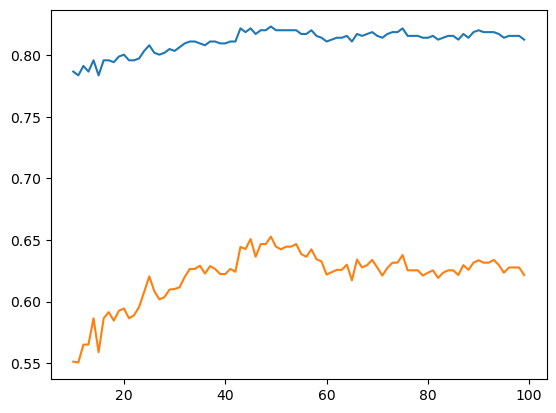

In [ ]:

plt.plot(sizes, accuracies)
plt.plot(sizes, av_f1s)


In [39]:
size =70


import pickle as pkl
with open('vlaad(rho=0.5)_agast(thr=3)_siftfd()_42.pkl', 'rb') as f:
    X_train_vlad, X_test_vlad, y_train, y_test, t_train, t_test = pkl.load(f)

    
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


threshspace = np.array([1/4, 1/2, 3/4])

probaspace = [0, 1/3, 2/3 ,1]
sample_weights = np.empty(len(y_train))
for p in probaspace:
    sample_weights[y_train==p] = np.sum(y_train == p)/len(y_train)

def to_classes(y):
    return np.sum(threshspace[:, None] < y[None, :], axis=0)

y_cls_test = to_classes(y_test)
y_cls_train = to_classes(y_train)

clf = LinearSVC(dual=True)
clf.fit(X_train_vlad[:,:size], y_cls_train)

# Predict on the test set
y_pred = clf.predict(X_test_vlad[:,:size])

# Print the classification report

print(classification_report((np.array(y_cls_test)-1)//2, (np.array(y_pred)-1)//2))

              precision    recall  f1-score   support

          -1       0.68      0.90      0.77       372
           0       0.53      0.10      0.16       104
           1       0.73      0.59      0.65       180

    accuracy                           0.69       656
   macro avg       0.64      0.53      0.53       656
weighted avg       0.67      0.69      0.64       656



c:\Users\shady\anaconda3\envs\COMP9517\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Experiment: Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
size = 17
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train_vlad[:,:size], y_cls_train)


y_pred = clf.predict(X_test_vlad[:,:size])

# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, (np.array(y_pred)-1)//2, digits=4))


NameError: name 'X_train_vlad' is not defined

In [ ]:
(0.8598 + 0.6569)/2

0.7583500000000001

In [ ]:
size = 100
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report


# 0 1/6 3/6 5/6 1

threshspace = [1/4, 1/2, 3/4]

n_clfs = len(threshspace)
probability = True
clfs = [SVC(C=1, probability=probability ) for _ in range(n_clfs)]


# input(sample_weights)
        

for clf, thresh in zip(clfs, threshspace):
    clf.fit(X_train_vlad[:,:size], y_train > thresh, sample_weight=sample_weights)
    

y_pred = 0
for clf in clfs:
    # Predict on the test set
    if probability:
        pred = clf.predict_proba(X_test_vlad[:,:size])[:, 1]
    else:
        pred = (clf.predict(X_test_vlad[:,:size]) + 1)//2
    y_pred += pred

# Predicted probability
y_pred/n_clfs
 

# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, y_pred/3 > 0.5))

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       445
           1       0.73      0.56      0.64       211

    accuracy                           0.79       656
   macro avg       0.77      0.73      0.75       656
weighted avg       0.79      0.79      0.78       656



In [ ]:

 
print(y_pred.mean()/3)
# Print the classification report
print(classification_report((np.array(y_cls_test)-1)//2, (y_pred-1)/3 > 0.5))

0.6568256167742595
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       445
           1       0.75      0.46      0.57       211

    accuracy                           0.78       656
   macro avg       0.76      0.69      0.71       656
weighted avg       0.77      0.78      0.76       656



In [ ]:
# https://www.sciencedirect.com/science/article/pii/S0031320321001394


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Now we use the histograms as inputs to the SVM classifier
# (nsamples, nfeatures)

X = images
y = probas

thresholds = [0, 0.33, 0.66, 1.0]
y_classes = [sum(1 for t in thresholds if value >= t) for value in y]

X_train, X_test, y_cls_train, y_cls_test, y_train, y_test = train_test_split(X, y_classes, probas, test_size=0.25, random_state=42)

vlad = Vlad(0.5, 128, get_sift_function(), vlad_clusters=16, output_size=1000)


X_train_vlad = vlad.fit_transform(X_train)
X_test_vlad = vlad.transform(X_test)


# Initialize and train the SVM classifier
clf = LinearSVC(dual=False, max_iter=100000)
clf.fit(X_train_vlad[:,:50], y_cls_train)

# Predict on the test set
y_pred = clf.predict(X_test_vlad[:,:50])

# Print the classification report

print(classification_report(y_cls_test, y_pred))

Vlad.fit: Extracting SIFT descriptors:  14%|█▍        | 273/1968 [00:06<00:40, 42.15it/s]

KeyboardInterrupt: 

Vlad.fit: Extracting SIFT descriptors:  14%|█▍        | 273/1968 [00:21<00:40, 42.15it/s]

Vlad.fit: Extracting SIFT descriptors:   0%|          | 4/1968 [00:00<00:58, 33.69it/s]

Vlad.fit: Extracting SIFT descriptors: 100%|██████████| 1968/1968 [00:44<00:00, 43.90it/s]
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Vlad.transform: 100%|██████████| 656/656 [00:14<00:00, 45.59it/s]


In [ ]:
X_train_vlad.shape, X_test_vlad.shape

((1968, 1000), (656, 1000))

NameError: name 'LinearSVC' is not defined

In [ ]:
vlad.outp

375

In [ ]:
from keras import Sequential, Model
from keras import optimizers, losses, metrics, Input, callbacks
from keras.layers import  Dense, Dropout, Activation, Multiply, Lambda, RepeatVector, Permute
from keras import backend as K
import tensorflow as tf
from tensorflow.python.ops import state_ops as tf_state_ops


class MaskingCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for m in MaskLayer.masking_vars:
            # Calculate the new length of the mask based on the epoch
            new_length = min(m.max_length, m.min_length +  ((m.max_length - m.min_length)*epoch)//m.mature_epochs)
            
            # Update the mask variable to have ones for the new_length and zeros for the rest
            new_mask = tf.concat([
                tf.ones((new_length,), dtype=tf.float32),
                tf.zeros((m.max_length - new_length,), dtype=tf.float32)
            ], axis=0)
            
            # Assign the new mask to the mask variable
            tf_state_ops.assign(m.var, new_mask)
            print(epoch, new_length)


class MaskLayer(tf.keras.layers.Layer):
    masking_vars = []
    def __init__(self, min_length, max_length, mature_epochs, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)
        self.mature_epochs = mature_epochs
        self.max_length = max_length
        self.min_length = min_length
        self.masking_vars.append(self)
        self.epoch = 0
        self.var = self.add_weight(
            shape=(self.max_length,),
            name="mask",
            initializer="zeros",
            trainable=False,
        )
    
    def call(self, input):
        """call method on the layer
        Args:
            inputs (tf.Tensor): sample wise loss values for a given batch
        Returns:
            tf.Tensor (shape = ()): loss threshold value for importance sampling
        """
    
        # # Calculate the new length of the mask based on the epoch
        # self.epoch += 1
        # new_length = min(self.max_length, self.min_length +  ((self.max_length - self.min_length)*self.epoch)//self.mature_epochs)
        
        # # Update the mask variable to have ones for the new_length and zeros for the rest
        # new_mask = tf.concat([
        #     tf.ones((new_length,), dtype=tf.float32),
        #     tf.zeros((self.max_length - new_length,), dtype=tf.float32)
        # ], axis=0)
        
        # # Assign the new mask to the mask variable
        # tf_state_ops.assign(self.var, new_mask)
        # # print(self.epoch, K.sum(self.var))
        return Multiply()([input, self.var[None,:]])


def feature_attention(inputs):
    # Compute the attention scores

    
    # inputs = Multiply()([MaskingArrayCallback(20, vlad.output_size, n_epochs).var[None,:], inputs])

    attention_probs = Dense(inputs.shape[-1], activation='softmax', name='attention_probs')(inputs)

    # print(attention_probs.shape)
    attention_probs = MaskLayer(1, vlad.output_size, n_epochs)(attention_probs)
    
    # Apply the attention scores
    attention_mul = Multiply()([inputs, attention_probs])

    return attention_mul



vlad.output_size = 300
n_epochs = 10000
# Define the input layer
input_layer = Input(shape=(vlad.output_size,))  # 'd' is the number of features




# Apply the feature attention mechanism
attention_output = feature_attention(input_layer)

# # Sum up the features to create a context vector (if desired)
# context_vector = Lambda(lambda x: K.sum(x, axis=1), name='context_vector')(attention_output)


model_layers = Sequential([
    Dropout(0.5),
    Dense(20, activation='sigmoid'),
    MaskLayer(3, 20, n_epochs),
    Dropout(0.1),
    Dense(1, activation='sigmoid'),
])(attention_output)

model = Model(inputs=[input_layer], outputs=[model_layers])
def custom_accuracy(y_true, y_pred):
    # Define the discrete values as a constant tensor
    discrete_values = K.constant([0, 1/3, 2/3, 1])

    # Find the difference between predicted values and discrete values
    # y_pred will be broadcasted to match the shape of discrete_values
    diffs = K.abs(discrete_values - y_pred[:, None])

    # Find the index of the minimum difference
    min_diff_index = K.argmin(diffs, axis=-1)

    # Gather the closest discrete values to the predictions
    closest = K.gather(discrete_values, min_diff_index)

    # Compute how many are correct
    correct_predictions = K.cast(K.equal(y_true, closest), K.floatx())

    # Return the mean accuracy over the batch
    return K.mean(correct_predictions)
model.compile(optimizers.Adam(learning_rate=1e-3), loss=losses.MeanSquaredError(), metrics=[
    custom_accuracy])
res = model.fit(X_train_vlad[:, :vlad.output_size], y_train, validation_split=0.2, epochs=n_epochs, batch_size=4, callbacks=[MaskingCallback()])

0 1
0 3
Epoch 1/10000
394/394 [==============================] - 2s 4ms/step - loss: 0.1919 - custom_accuracy: 0.1104 - val_loss: 0.1885 - val_custom_accuracy: 0.1237
1 1
1 3
Epoch 2/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1904 - custom_accuracy: 0.1104 - val_loss: 0.1880 - val_custom_accuracy: 0.1237
2 1
2 3
Epoch 3/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1898 - custom_accuracy: 0.1104 - val_loss: 0.1877 - val_custom_accuracy: 0.1237
3 1
3 3
Epoch 4/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1889 - custom_accuracy: 0.1104 - val_loss: 0.1871 - val_custom_accuracy: 0.1237
4 1
4 3
Epoch 5/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1863 - custom_accuracy: 0.1110 - val_loss: 0.1860 - val_custom_accuracy: 0.1237
5 1
5 3
Epoch 6/10000
394/394 [==============================] - 1s 3ms/step - loss: 0.1844 - custom_accuracy: 0.1104 - val_loss: 0.1849 - val_custom_accuracy: 0.123

In [ ]:
MaskLayer.masking_vars[0].var

<tf.Variable 'mask:0' shape=(200,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
res

In [ ]:

for i in range(1000):
    print(model.train_on_batch(X_train_vlad, y_train, return_dict=True))

{'loss': 0.11664357781410217, 'binary_accuracy': 0.8799999952316284, 'false_negatives_7': 26.0}
{'loss': 0.12185605615377426, 'binary_accuracy': 0.871999979019165, 'false_negatives_7': 27.0}
{'loss': 0.11391579359769821, 'binary_accuracy': 0.8826666474342346, 'false_negatives_7': 20.0}
{'loss': 0.13253846764564514, 'binary_accuracy': 0.8693333268165588, 'false_negatives_7': 31.0}
{'loss': 0.12036734074354172, 'binary_accuracy': 0.8773333430290222, 'false_negatives_7': 27.0}
{'loss': 0.11787330359220505, 'binary_accuracy': 0.8826666474342346, 'false_negatives_7': 29.0}
{'loss': 0.13940924406051636, 'binary_accuracy': 0.8640000224113464, 'false_negatives_7': 28.0}
{'loss': 0.1459229290485382, 'binary_accuracy': 0.871999979019165, 'false_negatives_7': 28.0}
{'loss': 0.13336646556854248, 'binary_accuracy': 0.874666690826416, 'false_negatives_7': 29.0}
{'loss': 0.12722356617450714, 'binary_accuracy': 0.874666690826416, 'false_negatives_7': 26.0}
{'loss': 0.11397475004196167, 'binary_accurac

In [ ]:
model.tra

              precision    recall  f1-score   support

           1       0.69      0.67      0.68        36
           2       0.40      0.57      0.47         7
           3       0.00      0.00      0.00         5
           4       0.82      0.82      0.82        77

    accuracy                           0.73       125
   macro avg       0.48      0.51      0.49       125
weighted avg       0.72      0.73      0.73       125



In [ ]:
from sklearn.preprocessing import normalize

In [ ]:


def vlad(clust_model, rho, descriptor_size):
    def vlad_process(image):

        # 1. Each image has n descriptors of fixed size m (=128)
        # 2. Find their cluster center that each of n descriptors belongs to
        # 3. For each descriptor subtract its assigned cluster center and add it to the vlad vector for that cluster
        # vlad_vector: has k rows and m (=128) columns each row is the local aggregation of descriptors from the image


        k = clust_model.n_clusters
        descriptors = get_descriptors(image)
        vlad_vector = np.zeros((k, descriptor_size)) # (k, 128) vector
        if descriptors is None:
            return vlad_vector.flatten()
        cluster_assignments = kmeans.predict(descriptors)
        vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

        for idx, cluster_idx in enumerate(cluster_assignments):
            vlad_vector[cluster_idx] += (descriptors[idx] - kmeans.cluster_centers_[cluster_idx])

        # Power normalization
        p = 0.5
        vlad_vector = np.sign(vlad_vector) * np.abs(vlad_vector) ** p
        
        # l2 Normalization
        vlad_vector = normalize(vlad_vector, norm='l2', axis=1)  # Normalize each row independently

        vlad_vectors.append(vlad_vector.flatten())

        return vlad_vector

    return vlad_process

get_feature_vector = vlad(kmeans, 1, 128)



vlad_vectors = []
pca = PCA(whiten=True)  # You may need to set the number of components if required

# Compute VLAD vectors
for descriptors in descriptors_list:
    if descriptors is None:
        continue
    cluster_assignments = kmeans.predict(descriptors)
    vlad_vector = np.zeros((k, descriptors.shape[1]))  # (k, 128) vector

    for idx, cluster_idx in enumerate(cluster_assignments):
        vlad_vector[cluster_idx] += (descriptors[idx] - kmeans.cluster_centers_[cluster_idx])

    # Power normalization
    p = 0.5
    vlad_vector = np.sign(vlad_vector) * np.abs(vlad_vector) ** p
    
    # l2 Normalization
    vlad_vector = normalize(vlad_vector, norm='l2', axis=1)  # Normalize each row independently

    vlad_vectors.append(vlad_vector.flatten())

# Concatenate all VLAD vectors from all images to fit the PCA
all_vlad_vectors = np.vstack(vlad_vectors)


# PCA Whitening
all_vlad_vectors = pca.fit_transform(all_vlad_vectors)

# l2 Normalization post PCA
all_vlad_vectors = normalize(all_vlad_vectors, norm='l2', axis=1)



In [ ]:
kmeans.n_clusters

6

In [ ]:

# VLAD
vlad_vectors = []
for image in tqdm(images_small, desc='Applying vlad'):
    vlad_vectors.append(get_feature_vector(image))


In [ ]:




# VLAD
vlad_vectors_2 = []
for image in tqdm(images_small, desc='Applying vlad'):
    vlad_vectors_2.append(get_feature_vector_2(image))

Applying vlad: 100%|██████████| 2000/2000 [00:43<00:00, 45.62it/s]


In [ ]:
# RUN svm
X = np.vstack(vlad_vectors)
y = probas[:X.shape[0]]

thresholds = [0, 0.33, 0.66, 1.0]
y_classes = [sum(1 for t in thresholds if value >= t) for value in y]

X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.86      0.78       192
           2       0.38      0.17      0.23        30
           3       0.00      0.00      0.00        19
           4       0.66      0.64      0.65       126

    accuracy                           0.68       367
   macro avg       0.44      0.42      0.42       367
weighted avg       0.63      0.68      0.65       367



/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# RUN svm
from sklearn.svm import SVC
get_feature_vector_2 = vlad(kmeans, 0.5, 128)

for i in range(len(vlad_vectors_2)):
    if len(vlad_vectors_2[i].shape) ==2:
        vlad_vectors_2[i] = vlad_vectors_2[i].flatten()
X_train = np.vstack(vlad_vectors_2)
y_train = probas[:X.shape[0]]

thresholds = [0, 0.33, 0.66, 1.0]





X_test = np.vstack([get_feature_vector_2(image) for image in tqdm(images[2000:4000],desc='working', total=2000)])
y_test = [sum(1 for t in thresholds if value >= t) for value in probas[2000:]] 


y_train = [sum(1 for t in thresholds if value >= t) for value in probas[:X.shape[0]]]

# X_train, X_test, y_train, y_test = train_test_split(X, y_classes, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
clf = SVC(max_iter=10000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

working:  31%|███       | 624/2000 [00:13<00:29, 45.98it/s]


              precision    recall  f1-score   support

           1       0.78      0.74      0.76       468
           2       0.00      0.00      0.00        84
           3       0.00      0.00      0.00        11
           4       0.16      0.48      0.24        61

    accuracy                           0.60       624
   macro avg       0.24      0.30      0.25       624
weighted avg       0.60      0.60      0.59       624



/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ezra/Programming/Projects/Uni/COMP9517/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
from typing import *

class ELPVPipeline:
    preprocessing: Callable
    preprocessing: Callable
    preprocessing: Callable
    preprocessing: Callable
    